In [2]:
%load_ext autoreload
%autoreload 2

from minisom import MiniSom, SOM, SOM2, slideAcc, binToOrthog
import os
import numpy as np

from glob import glob
# import matplotlib as plt


%pylab inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Cython in Ipython notebooks
#  %load_ext Cython  # to enable Cython
#  %%cython  # in cell to run to compile it

Exemplar projection


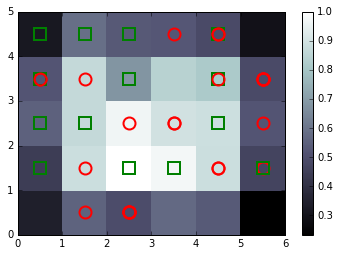

Ideal exemplar projection


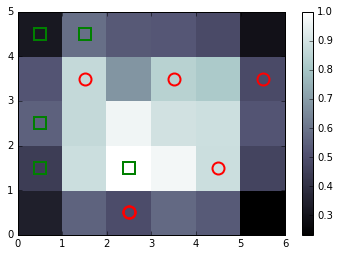

In [13]:
# init som
# f = '4750.csv'


fileDir = 'FeatCombIdeal/FeatIdealAdultBL/'

# fileDir = '../../KARS_reinf/Python/FeatSeenBySubAdultBL/'

# fileDir = '../../KARS_reinf/Python/FeatSeenBySubBaseline/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubLabel/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubSup/'
files = glob( fileDir + '*.csv') #fileDir+'4760.csv'


mod = SOM( files[1], learning_rate=.1) #, predThresh=.9) 
mod.pertData(.7)
mod.show()
mod.showIdeal() # show good category examples (ground truth) stored in stimuli.csv





Qnt error current Sample: 1.9390
SOM/Child/True Label: B/A/A.
Project prototype distances: 
[] []
Iter 1
Exemplar projection


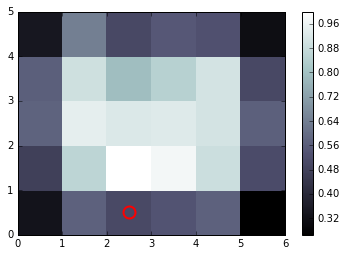

In [14]:
# train incrementally example 

somLab, childLab = mod.predOne( verbose=True)
mod.trainOne()  #  don't use mod.trainOneGliozzi()
print( 'Iter %d'% mod.dataIdx )
mod.show(mod.dataIdx)

# mod.showIdeal()  # ideal exemplars on trained map




In [15]:
# Match based on side feature
mod = SOM2( files[1], learning_rate=.05) 

# mod.show()
mod.trainOne()

Qnt error to start: 0.20


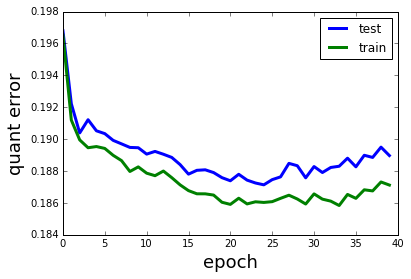

In [16]:
# look at quanitzation error over learning

#  quantization error is average distance between BMU and the data
#  Plotting normalized qE by # features to be consistent across different prediction rules

# matching by appearance, decision based on side
# mod = SOM( files[1], learning_rate=.05, bmuFeatures=1, predMode='side'  ) 
mod = SOM( files[1], learning_rate=.05)

numTrain  = len(mod.data)/2
numFts = mod.data.shape[1]


# # standard appearance model, with protoypes
# mod = SOM( files[1], learning_rate=.05  ) #, predThresh=.9) 

mod.pertData(.2)
print( 'Qnt error to start: %.2f' % ( mod.som.quantization_error(mod.data)/numFts))
# mod.show()

# for i1 in range( len(mod.data)):
#     print( 'Qnt error after iter %d: %.2f' % ( i1,mod.som.quantization_error(mod.data)))
#     mod.trainOne()  #  don't use mod.trainOneGliozzi()   
# print( 'Iter %d'% mod.dataIdx )


Niters = 40
qE = []
qETrain = []
for ep in range(Niters):
#     print('Training random once')
    mod.som.train_random_once(mod.data[:numTrain])
    # mod.som.train_random(mod.data, 2)
    errorTest = mod.som.quantization_error(mod.data[numTrain:])/numFts #normalize by # features
    errorTrain = mod.som.quantization_error(mod.data[:numTrain])/numFts
    qE.append(errorTest)
    qETrain.append(errorTrain)
#     print( 'Qnt error after epoch %d: %.2f' % (error ))

fSize = 18
plot( array(qE), linewidth=3, label= 'test')
plot( array(qETrain), linewidth=3, label= 'train')
ylabel( 'quant error', fontsize=fSize)
xlabel( 'epoch', fontsize=fSize)
legend()

# figure()
# mod.show(indices=np.arange(0, numTrain))
# print( 'Train samples')
# mod.show(indices=np.arange(numTrain,len(mod.data)))
# print( 'Test samples')

savefig( 'qntErrorByEpoch.png')

In [17]:
# mod.data[:numTrain]
mod.data[9]

array([-1.,  1., -1.,  1., -1.,  1.,  0.,  1., -1.,  1., -1.,  1., -1.,  1.])

In [18]:
'''
Look at differences between prediction rules
  * Previously, prediction given  by matching to stored updating prototype 
  
  * Now, we determine BMU based on subset of features, ignoring side.
    Then use the side (left/right) feature to make decision.
    In that case, make SOM class have a "predMode" attribute  
'''

# len(mod.data)
# mod.data.shape


# mod = SOM( files[1], learning_rate=.3, predThresh=.9, bmuFeatures=1) 


'\nLook at differences between prediction rules\n  * Previously, prediction given  by matching to stored updating prototype \n  \n  * Now, we determine BMU based on subset of features, ignoring side.\n    Then use the side (left/right) feature to make decision.\n    In that case, make SOM class have a "predMode" attribute  \n'

In [19]:
import time

Exemplar projection


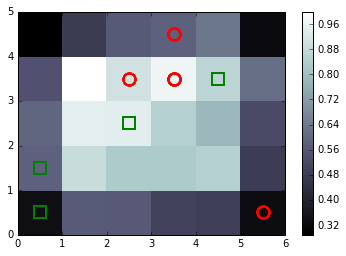

Exemplar projection


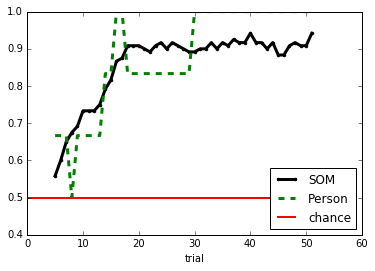

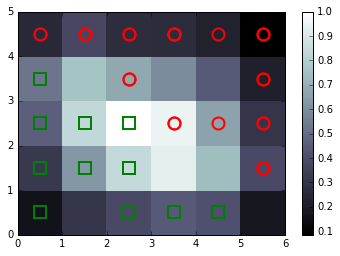

Qnt error after 1 epoch: 1.85
4.52 seconds elapsed


In [20]:
#####  Calculate learning curve (several initializations)


t = time.time()  # for clocking


f = files[1]
removeProp = .6 #5
lrnRt = .3
iters = 20 # 30

# initialize standard SOM
mod = SOM( f, learning_rate= lrnRt, predThresh=.7)


# show untrained map
mod.show()

# show curves
figure()
mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
mod.showLearnCurves(window=6)

#show trained map
figure()
mod.show()

print( 'Qnt error after 1 epoch: %.2f'%  mod.som.quantization_error(mod.data))


# do stuff
elapsed = time.time() - t
print( '%.2f seconds elapsed' % elapsed)


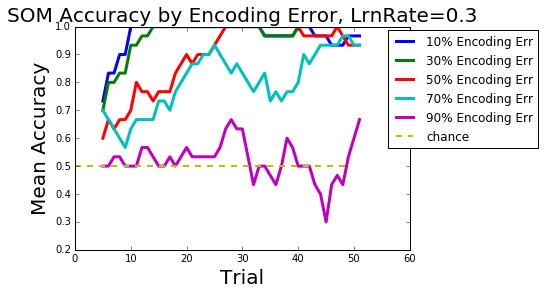

In [21]:
# make some nice larning curves (for encoding error)

f = files[1]
lrnRt = .3
iters = 5 # 30
w = 6
predThresh = .7


# for saving figures
outDir = 'SOMfigs/'
if not os.path.exists( outDir ):
    os.mkdir( outDir )         

##-------------------------------------------------

# loop through different removeProp (% encoding error)
for removeProp in np.arange(.1,1, .2):                       
    mod = SOM( f, learning_rate= lrnRt, predThresh=.7)
    meanAcc  = mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
    # show them 
    plot( slideAcc( meanAcc, window=w), linewidth=3, label=('%.0f%% Encoding Err'% (100*removeProp)))
# chance line    
plot( np.arange(50), .5*ones(50 ), '--', linewidth=2, label='chance')    
xlabel('Trial', fontsize=20)
ylabel( 'Mean Accuracy', fontsize=20)
title('SOM Accuracy by Encoding Error, LrnRate=0.3', fontsize=20)
# show legend
lgd = legend(bbox_to_anchor=(1.4, 1.01)) 

# save it  
saveFile = outDir + 'removePropFig.png'
savefig( saveFile, bbox_extra_artists=(lgd,), bbox_inches='tight')



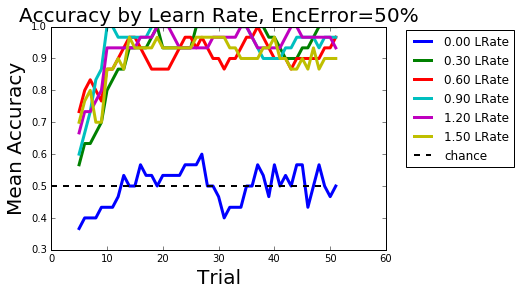

In [22]:
##-------------------------------------------------
# plot function of learning rate


removeProp = .5


figure()
# loop through different learning rates % fixed encoding error

for lrnRt in np.arange(.0,1.8, .3):                       
    mod = SOM( f, learning_rate= lrnRt, predThresh=predThresh)
    meanAcc  = mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
    # show them 
    plot( slideAcc( meanAcc, window=w), linewidth=3, label=('%.2f LRate'% (lrnRt)))
# chance line    
plot( np.arange(50), .5*ones(50 ), '--', linewidth=2, label='chance')    
xlabel('Trial', fontsize=20)
ylabel( 'Mean Accuracy', fontsize=20)
title('Accuracy by Learn Rate, EncError=50%', fontsize=20)
# show legend
lgd = legend(bbox_to_anchor=(1.4, 1.01)) 

# save it  
saveFile = outDir + 'lrnRate.png'
savefig( saveFile, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [23]:
# lets now mess with learning rate 

def pertData( self, p=.2, verbose=False):
    if verbose:
        print( 'Making %.2f percent of inputs 0.0' %(p*100))
    # randomly get proportion of indices to switch, then replace
    p = max( min(p,1), 0 ) # set in range [0,1]
    
    sh = self.data.shape
    noiseIndex = np.random.binomial(1,p,(sh[0], sh[1]-1 ) )  #ones at p proportion of samples
    self.data[noiseIndex ==1 ] = 0
    
    
mod = SOM( f)    
pertData( mod)
# mod.data
# mod.som.weights
    

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 14 but corresponding boolean dimension is 13


In [24]:
##  fit learning curve to participants

import scipy.optimize as opt


f = files[2]
iters = 30

def subModError( x0):
    lrnRt = 3*x0[0]
    removeProp = 3*x0[1]
    
    
    mod = SOM( f, learning_rate= lrnRt )
    mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
    
    # return norm or error divided my length
    error = norm(mod.somAcc[ ~np.isnan(mod.acc)]  - mod.acc[~np.isnan(  mod.acc)])/np.sum( np.sum( ~np.isnan(mod.acc))) 
    print('learn rate: %.4f, removed prop: %.4f, error: %.4f' %( lrnRt, removeProp, error) )
    return error
    
# subModError( array([.2,.5]))


# res = opt.minimize(subModError, [.1,.1], method= 'powell',  #'nelder-mead',
#                         options={'xtol': 1e-3, 'disp': True} )

In [25]:
# 3*res.x

In [26]:
# how well do SOMs and participants agree in decisions?
#      train incrementally and combine all participant scores

# def allFilesPred(  ):
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubAdultBL/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubBaseline/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubLabel/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubSup/'


files = glob( fileDir + '*.csv') #fileDir+'4760.csv'
agVec = np.array([])
for idx,f in enumerate(files):  
    mod = SOM( f, learning_rate=0.2 ) #'4750.csv'
    agree =  mod.predAll( verbose=False, skip=0, reps=1) 
    
    # compile how many times SOM and infant agree
    agVec = np.append( agVec, agree)             

print fileDir
print( 'SOM and participants agee M+SD: %.2f +- %.2f '% (nanmean( agVec), nanstd(agVec))  )



FeatCombIdeal/FeatIdealAdultBL/
SOM and participants agee M+SD: 0.72 +- 0.45 


In [27]:
# Optimize learning rate to maximize SOM/infant prediction correlation

def allFilesPred( x0 ): # learning rate
    fileDir = '../../KARS_reinf/Python/FeatSeenBySubBaseline/'
    files = glob( fileDir + '*.csv') #fileDir+'4760.csv'
    agVec = np.array([])
    for idx,f in enumerate(files):
        #print f
        mod = SOM( f, learning_rate=x0 ) # 0.3
        agree =  mod.predAll( verbose=False, skip=8, reps=3) 
        # compile how many times SOM and infant agree
        agVec = np.append( agVec, agree)             
        
    print(fileDir)
    print( 'Learning rate: %.2f' % x0)        
    print( 'SOM and participants agee M+SD: %.3f +- %.3f '% (nanmean( agVec), nanstd(agVec))  )
#     return nanmean( agVec)


# for lrnRt in np.arange(.1,2,.2):
# allFilesPred( lrnRt) 
    
# x = fmin( 

In [28]:
# f

In [29]:
# how to use
# fileDir = '../../KARS_reinf/Python/FeatSeenBySub/'

mod = SOM( '4750.csv', learning_rate=0.3 ) #fileDir+'4760.csv')
mod.train(20)
# mod.trainOneGliozzi()
mod.show()

# print( 'SOM with infant exemplars')
mod.showIdeal()
print( 'Class separation: %.2f' %mod.separation())

# print mod.acc
# print nanmean( mod.acc)


IOError: 4750.csv not found.

In [ ]:
# import sklearn

In [ ]:
# run the model fitting N times, get mean class separation
N = 20
sepList = np.arange(N,dtype=float)
for i1 in range(N):
    mod = SOM('4750.csv')
    mod.train(20)
    sepList[i1] = mod.separation()

sepList.mean()
# mod.show()
# mod.showIdeal()


In [ ]:
# loop through files and train up SOMs, measure class separation
# fileDir = '../../KARS_reinf/Python/FeatSeenBySub/'
resultFile = 'catSeparation.txt'
fOut = open(resultFile, 'w')
fOut.write( 'subID\tcatSep\n')


files= glob( fileDir+'*.csv')
N = 50 # number models to generate per participant
iters = 30 # number training iterations

for f in files:
    participant = f.split('/')[-1].split('.')[0]
    sepList = np.arange(N,dtype=float) # init list
    for i1 in range(N):            
        mod = SOM( f)
        mod.train(iters)
        sepList[i1] = mod.separation()
    # output result
    fOut.write( '%s\t%.4f\n'%(participant, sepList.mean()) )
    print( 'Participant %s, Category separation: %.3f' % (participant, sepList.mean()) )

    
fOut.close()

In [ ]:
r.random()

In [ ]:
#  cat catSeparation.txt


In [ ]:
# x = arange(5)
# x[:0]

In [ ]:
20 <np.inf